In [1]:
import numpy as np 
import re  #regular expression
from bs4 import BeautifulSoup
import pandas as pd 
from sklearn import model_selection, preprocessing
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, Conv1D, MaxPooling1D, Embedding, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import Constant
from sklearn.metrics import confusion_matrix

In [2]:
print('Indexing word vectors.')
#Many thanks to rtatman for hosting the GloVe word embeddings dataset on Kaggle
#https://www.kaggle.com/rtatman/glove-global-vectors-for-word-representation
GLOVE_DIR = '/kaggle/input/glove-global-vectors-for-word-representation/'
embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt')) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs
print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [3]:
print('Reading the datasets')
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

Reading the datasets


In [4]:
print('Colimns of the training and test datasets are:')
print(train_df.keys())
print(test_df.keys())

Colimns of the training and test datasets are:
Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')
Index(['id', 'keyword', 'location', 'text'], dtype='object')


In [5]:
url_re = r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))'
# Thanks to l3nnys for this nice tutorial on text preprocessing
#https://www.kaggle.com/l3nnys/useful-text-preprocessing-on-the-datasets

def remove_html(text):
    '''
    remove the HTML tags and URLS from the tweets
    '''
    if text:
        # BeautifulSoup on content
        soup = BeautifulSoup(text, "html.parser")
        # Stripping all <code> tags with their content if any
        if soup.code:
            soup.code.decompose()
        # Get all the text out of the html
        text =  soup.get_text()
        # Returning text stripping out all uris
        return re.sub(url_re, "", text)
    else:
        return ""
  
train_df['text'] = train_df['text'].map(lambda x: remove_html(x))
test_df['text'] = test_df['text'].map(lambda x: remove_html(x))

In [6]:
# Removing emojis thanks to this instruction on stackoverflow:
#https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python

def remove_emojis(text):
  emoji_pattern = re.compile("["
        r"\U0001F600-\U0001F64F"  # emoticons
        r"\U0001F300-\U0001F5FF"  # symbols & pictographs
        r"\U0001F680-\U0001F6FF"  # transport & map symbols
        r"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
  text = emoji_pattern.sub(r'', text)# no emoji 
  
  return text

example_text = r'This dog is funny \U0001f602'
train_df['text'] = train_df['text'].map(lambda x: remove_emojis(x))
test_df['text'] = test_df['text'].map(lambda x: remove_emojis(x))

In [7]:
vocab_size = 10000
embedding_dim = 100
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
validation_split = 0.3

tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(train_df.text)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

training_sequences = tokenizer.texts_to_sequences(train_df.text)
training_padded = pad_sequences(training_sequences, maxlen = max_length, 
                                padding = padding_type, truncating = trunc_type)
print('Shape of the data vector is', training_padded.shape, train_df.target.shape)

Found 18099 unique tokens.
Shape of the data vector is (7613, 50) (7613,)


In [8]:
print('Preparing the embedding matrix')
num_words = min(vocab_size, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, index in word_index.items():
  if index >= vocab_size:
    continue
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

Preparing the embedding matrix


In [9]:
embedding_layer = Embedding(num_words, embedding_dim, 
                           embeddings_initializer = Constant(embedding_matrix), 
                           input_length = max_length, 
                           trainable = False)

In [10]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(training_padded, 
                                                                      train_df.target, 
                                                                      test_size = validation_split, 
                                                                      random_state=1)

In [11]:
#Defining a Sequential Keras model with Convolution & Global Max Pooling
sequence_input = Input(shape = (max_length, ))
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(32, 5, activation='relu')(embedded_sequences)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.5)(x)
x = Dense(24, activation = 'relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation = 'sigmoid')(x)
model =  Model(sequence_input, output)
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(lr = .0002) ,metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size = 64, epochs = 20, validation_data = (X_valid, y_valid))

Train on 5329 samples, validate on 2284 samples
Epoch 1/20
5329/5329 [==============================] - 2s 364us/sample - loss: 0.8298 - accuracy: 0.5155 - val_loss: 0.6747 - val_accuracy: 0.5968
Epoch 2/20
5329/5329 [==============================] - 1s 162us/sample - loss: 0.7197 - accuracy: 0.5498 - val_loss: 0.6618 - val_accuracy: 0.6432
Epoch 3/20
5329/5329 [==============================] - 1s 162us/sample - loss: 0.6899 - accuracy: 0.5757 - val_loss: 0.6484 - val_accuracy: 0.6751
Epoch 4/20
5329/5329 [==============================] - 1s 163us/sample - loss: 0.6641 - accuracy: 0.5984 - val_loss: 0.6362 - val_accuracy: 0.7010
Epoch 5/20
5329/5329 [==============================] - 1s 162us/sample - loss: 0.6404 - accuracy: 0.6298 - val_loss: 0.6172 - val_accuracy: 0.7316
Epoch 6/20
5329/5329 [==============================] - 1s 162us/sample - loss: 0.6260 - accuracy: 0.6502 - val_loss: 0.5961 - val_accuracy: 0.7386
Epoch 7/20
5329/5329 [==============================] - 1s 160us

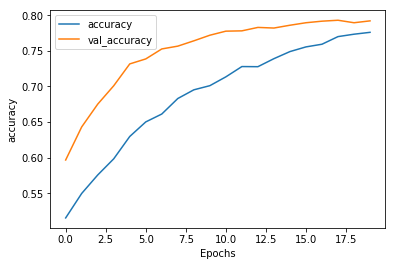

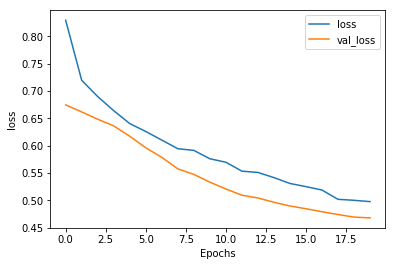

In [12]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [13]:
pred_valid = model.predict(X_valid)

array([[0.51346123],
       [0.37131658],
       [0.3449204 ],
       ...,
       [0.11744303],
       [0.08342443],
       [0.26651904]], dtype=float32)

In [14]:
pred_valid = np.round(pred_valid).astype(int)

array([[1],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [15]:
confusion_matrix(y_valid, pred_valid)

array([[1151,  175],
       [ 300,  658]])

In [16]:
test_sequences = tokenizer.texts_to_sequences(test_df.text)
test_padded = pad_sequences(test_sequences, maxlen = max_length, 
                                padding = padding_type, truncating = trunc_type)
print('Shape of the data vector is', test_padded.shape)

Shape of the data vector is (3263, 50)


In [17]:
predictions = model.predict(test_padded)

In [18]:
predictions = np.round(predictions).astype(int).flatten()

In [20]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

In [21]:
sample_submission["target"] = predictions.astype(int)

In [22]:
sample_submission.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1


In [23]:
sample_submission.to_csv("submission.csv", index=False)